## 필수과제1.2.
> softmax함수를 통해 스코어링을 재정의하고 다시 점수를 출력하고 분포 재확인
* 분포가 극단적으로 치우쳐져 있기 때문에 단순히 softmax 를 적용하면 거의 대부분의 값이 0으로 수렴한다.
* score 에 로그를 취하거나 scaling 을 해도 동일하다.
* 즉, 해당 데이터 상에서 이벤트의 수도 차이가 나는 가운데 구매 이벤트의 경우 특정 몇개의 아이템에 몰려있어 점수 변환시 극단적인 분포를 벗어나기 어렵다.
* 데이터 상에서 product_id = 5809910 해당 제품의 구매건은 전체 구매의 7% 를 차지한다.
* 전체 구매가 진행된 unique item 이 26815 개 인데 1개의 제품이 전체 구매건의 7% 를 차지하는건 굉장히 극단적인 case 라 할 수 있다.

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import seaborn as sns

In [2]:
df=pd.read_csv('../dataset/2019-Dec.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533286 entries, 0 to 3533285
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 242.6+ MB


In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-12-01 00:00:00 UTC,remove_from_cart,5712790,1487580005268456287,NaN,f.o.x,6.270,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc
1,2019-12-01 00:00:00 UTC,view,5764655,1487580005411062629,NaN,cnd,29.050,412120092,8adff31e-2051-4894-9758-224bfa8aec18
2,2019-12-01 00:00:02 UTC,cart,4958,1487580009471148064,NaN,runail,1.190,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554
3,2019-12-01 00:00:05 UTC,view,5848413,1487580007675986893,NaN,freedecor,0.790,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4
4,2019-12-01 00:00:07 UTC,view,5824148,1487580005511725929,NaN,NaN,5.560,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5


In [4]:
df['event_type'].value_counts()

event_type
view                1728331
cart                 927124
remove_from_cart     664655
purchase             213176
Name: count, dtype: int64

#### Softmax function
* $f_i(x) = \frac{exp(x_i)}{\sum_j{exp(x_j)}}$

In [5]:
weights = {
    'view':1,
    'cart':3,
    'purchase':5
}
event_df = df.loc[df['event_type'].isin(['view','cart','purchase'])]
event_df['score'] = event_df['event_type'].map(weights)
product_scores = event_df.groupby('product_id')['score'].sum().reset_index()

## 추천지수가 높은 제품 상위 10개 출력
product_scores=product_scores.sort_values(by='score', ascending=False)
product_scores

/var/folders/1l/w3vzbf215cs4ll30rh71l7wr6ghggx/T/ipykernel_11326/2550288251.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['score'] = event_df['event_type'].map(weights)


,product_id,score
17481,5809910,52253
16049,5802432,20129
7136,5700037,20017
28944,5854897,17311
17483,5809912,16946
...,...,...
6238,5691801,1
6239,5691806,1
41258,5905774,1
41260,5905779,1


In [6]:
def softmax_function(x):
    return np.exp(x) / sum(np.exp(x))

def stable_softmax(x):
    z = x - np.max(x)
    return np.exp(z) / np.sum(np.exp(z))

In [7]:
softmax_function(product_scores['score'])

/opt/homebrew/Caskroom/miniforge/base/envs/bq_python/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


17481     NaN
16049     NaN
7136      NaN
28944     NaN
17483     NaN
         ... 
6238    0.000
6239    0.000
41258   0.000
41260   0.000
2056    0.000
Name: score, Length: 44081, dtype: float64

In [8]:
from scipy.special import softmax
product_scores['softmax_score'] = softmax(product_scores['score'])
product_scores = product_scores.dropna()
product_scores['softmax_score'].describe() 

count   44081.000
mean        0.000
std         0.005
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         1.000
Name: softmax_score, dtype: float64

In [9]:
product_scores[product_scores['softmax_score']>0.0]

,product_id,score,softmax_score
17481,5809910,52253,1.000


In [10]:
product_scores['softmax_log_score'] = stable_softmax(np.log1p(product_scores['score']))

In [11]:
# 5809910 해당 제품의 구매건은 전체 구매의 7% 를 차지한다.
df.loc[(df['product_id'] == 5809910)&(df['event_type']=='purchase')].shape[0] / df[df['event_type']=='purchase'].shape[0]

0.007782301947686419

In [12]:
# 전체 구매가 진행된 unique item 이 26815 개 인데 1개의 제품이 전체 구매건의 7% 를 차지하는건 굉장히 극단적인 case 라 할 수 있다.
df.loc[df['event_type']=='purchase','product_id'].nunique()

26815

In [13]:
product_scores[product_scores['softmax_log_score']>0.0]

,product_id,score,softmax_score,softmax_log_score
17481,5809910,52253,1.000,0.009
16049,5802432,20129,0.000,0.004
7136,5700037,20017,0.000,0.004
28944,5854897,17311,0.000,0.003
17483,5809912,16946,0.000,0.003
...,...,...,...,...
6238,5691801,1,0.000,0.000
6239,5691806,1,0.000,0.000
41258,5905774,1,0.000,0.000
41260,5905779,1,0.000,0.000


In [14]:
product_scores['softmax_log_score'].describe()

count   44081.000
mean        0.000
std         0.000
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         0.009
Name: softmax_log_score, dtype: float64

In [15]:
product_scores['softmax_log_score'].value_counts()

softmax_log_score
0.000    2887
0.000    1388
0.000    1105
0.000     979
0.000     786
         ... 
0.000       1
0.000       1
0.000       1
0.000       1
0.009       1
Name: count, Length: 1574, dtype: int64

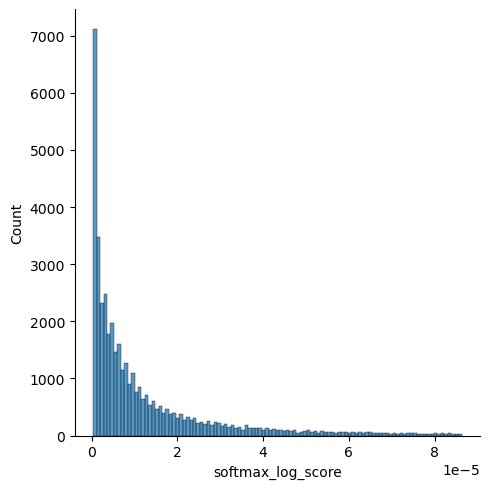

In [16]:
plot_df = product_scores[product_scores['softmax_log_score'] < product_scores['softmax_log_score'].quantile(.95)]
sns.displot(plot_df['softmax_log_score'])

In [17]:
product_scores['minmaxsc_score'] = (product_scores['score'] - product_scores['score'].min()) / (product_scores['score'].max()-product_scores['score'].min())
product_scores['minmaxsc_score']

17481   1.000
16049   0.385
7136    0.383
28944   0.331
17483   0.324
         ... 
6238    0.000
6239    0.000
41258   0.000
41260   0.000
2056    0.000
Name: minmaxsc_score, Length: 44081, dtype: float64

In [18]:
product_scores['minmaxsc_score'].head(20)

17481   1.000
16049   0.385
7136    0.383
28944   0.331
17483   0.324
19099   0.273
10530   0.231
42176   0.223
17482   0.220
10492   0.210
22836   0.205
320     0.187
27074   0.187
34853   0.166
25530   0.160
7145    0.159
19206   0.158
14712   0.157
23673   0.157
1865    0.145
Name: minmaxsc_score, dtype: float64

In [19]:
product_scores['minmaxsc_score'].describe()

count   44081.000
mean        0.002
std         0.009
min         0.000
25%         0.000
50%         0.001
75%         0.002
max         1.000
Name: minmaxsc_score, dtype: float64

In [20]:
product_scores['minmaxsc_score'].quantile(.8)

0.002621909209216872

In [21]:
product_scores.head()

,product_id,score,softmax_score,softmax_log_score,minmaxsc_score
17481,5809910,52253,1.000,0.009,1.000
16049,5802432,20129,0.000,0.004,0.385
7136,5700037,20017,0.000,0.004,0.383
28944,5854897,17311,0.000,0.003,0.331
17483,5809912,16946,0.000,0.003,0.324


In [ ]:
product_scores = event_df.groupby('product_id')['score'].sum().reset_index()